In [1]:
import random
import numpy as np
from PIL import  Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Normalize

from data_generation.image_classification import generate_dataset
from helpers import index_splitter, make_balanced_sampler
from stepbystep.v1 import StepByStep

In [2]:
single = np.array(
    [[[[5,0,8,7,8,1],
       [1,9,5,0,7,7],
       [6,0,2,4,6,6],
       [9,7,6,6,8,4],
       [8,3,8,5,1,3],
       [7,2,7,0,1,0]]]]
)
single.shape

(1, 1, 6, 6)

In [3]:
identity = np.array(
    [[[[0,0,0],
       [0,1,0],
       [0,0,0]]]]
)
identity.shape

(1, 1, 3, 3)

In [4]:
region = single[:,:, 0:3, 0:3]
filtered_region = region * identity
total = filtered_region.sum()
total

9

In [5]:
image = torch.as_tensor(single).float()
kernel_identity = torch.as_tensor(identity).float()

In [6]:
convolved = F.conv2d(image, kernel_identity, stride=1)
convolved

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]])

In [7]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
conv(image)

tensor([[[[ 0.9415,  3.8155,  2.8032,  2.9047],
          [ 2.6962,  1.7156,  1.2290,  3.1946],
          [-0.6349,  1.6556,  0.9427,  2.1968],
          [ 1.2619,  4.3872,  2.4251,  2.7447]]]],
       grad_fn=<ConvolutionBackward0>)

In [8]:
conv_multiple = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1)
conv_multiple.weight

Parameter containing:
tensor([[[[ 0.1157,  0.2997,  0.2083],
          [-0.3165, -0.3146,  0.1714],
          [ 0.1225,  0.2609,  0.0883]]],


        [[[ 0.0038, -0.2182,  0.2695],
          [-0.0457, -0.1217,  0.0588],
          [ 0.0610, -0.3087,  0.1400]]]], requires_grad=True)

In [9]:
with torch.no_grad():
    conv.weight[0] = kernel_identity
    conv.bias[0] = 0

In [10]:
conv(image)

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]], grad_fn=<ConvolutionBackward0>)

In [11]:
convolved_stride2 = F.conv2d(image, kernel_identity, stride=2)
convolved_stride2

tensor([[[[9., 0.],
          [7., 6.]]]])

In [12]:
constant_padder = nn.ConstantPad2d(padding=1, value=0)
constant_padder(image)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [13]:
padded = F.pad(image, pad=(1,1,1,1), mode='constant', value=0)

In [14]:
padded

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [15]:
replication_padder = nn.ReplicationPad2d(padding=1)
replication_padder(image)

tensor([[[[5., 5., 0., 8., 7., 8., 1., 1.],
          [5., 5., 0., 8., 7., 8., 1., 1.],
          [1., 1., 9., 5., 0., 7., 7., 7.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [9., 9., 7., 6., 6., 8., 4., 4.],
          [8., 8., 3., 8., 5., 1., 3., 3.],
          [7., 7., 2., 7., 0., 1., 0., 0.],
          [7., 7., 2., 7., 0., 1., 0., 0.]]]])

In [16]:
reflection_padder = nn.ReflectionPad2d(padding=1)
reflection_padder(image)

tensor([[[[9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 5., 0., 8., 7., 8., 1., 8.],
          [9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 6., 0., 2., 4., 6., 6., 6.],
          [7., 9., 7., 6., 6., 8., 4., 8.],
          [3., 8., 3., 8., 5., 1., 3., 1.],
          [2., 7., 2., 7., 0., 1., 0., 1.],
          [3., 8., 3., 8., 5., 1., 3., 1.]]]])

In [17]:
F.pad(image, pad=(1,1,1,1), mode='circular')

tensor([[[[0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.],
          [7., 1., 9., 5., 0., 7., 7., 1.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [4., 9., 7., 6., 6., 8., 4., 9.],
          [3., 8., 3., 8., 5., 1., 3., 8.],
          [0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.]]]])

In [18]:
edge = np.array(
    [[[[0, 1, 0],
       [1, -4, 1],
       [0, 1, 0]]]]
)
kernel_edge = torch.as_tensor(edge).float()
kernel_edge.shape

torch.Size([1, 1, 3, 3])

In [19]:
padded = F.pad(image, (1,1,1,1), mode='constant', value=0)
conv_padded = F.conv2d(padded, kernel_edge, stride=1)
conv_padded

tensor([[[[-19.,  22., -20., -12., -17.,  11.],
          [ 16., -30.,  -1.,  23.,  -7., -14.],
          [-14.,  24.,   7.,  -2.,   1.,  -7.],
          [-15., -10.,  -1.,  -1., -15.,   1.],
          [-13.,  13., -11.,  -5.,  13.,  -7.],
          [-18.,   9., -18.,  13.,  -3.,   4.]]]])

In [20]:
pooled = F.max_pool2d(conv_padded, kernel_size=2)
pooled

tensor([[[[22., 23., 11.],
          [24.,  7.,  1.],
          [13., 13., 13.]]]])

In [21]:
maxpool4 = nn.MaxPool2d(kernel_size=4)
pooled4 = maxpool4(conv_padded)
pooled4

tensor([[[[24.]]]])

In [22]:
F.max_pool2d(conv_padded, kernel_size=3, stride=1)

tensor([[[[24., 24., 23., 23.],
          [24., 24., 23., 23.],
          [24., 24., 13., 13.],
          [13., 13., 13., 13.]]]])

In [23]:
flattend = nn.Flatten()(pooled)
flattend

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

In [24]:
pooled.view(1, -1)

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

In [25]:
images, labels = generate_dataset(img_size=10, n_images=1000, binary=False, seed=17)

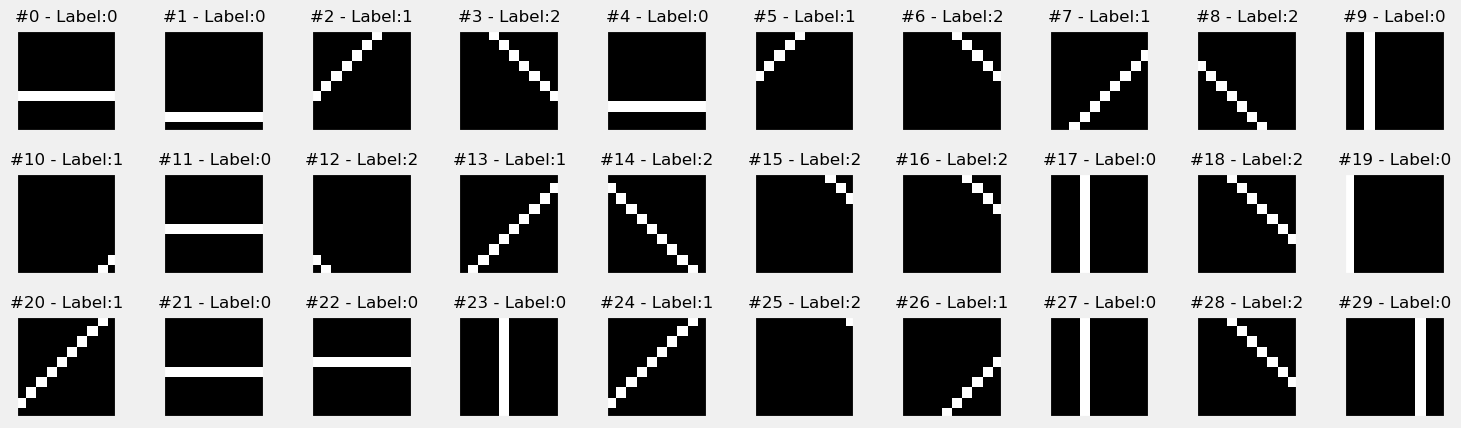

In [26]:
from plots.chapter5 import *
fig = plot_images(images, labels, n_plot=30)

In [27]:
class TransformedTensorDataset(Dataset):
    def __init__(self,x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
    def __getitem__(self, index):
        x = self.x[index]
        if self.transform:
            x = self.transform(x)
        return x, self.y[index]
    def __len__(self):
        return len(self.x)

In [28]:
x_tensor = torch.as_tensor(images/255).float()
y_tensor = torch.as_tensor(labels).long()

train_idx, val_idx = index_splitter(len(x_tensor), [80,20])

x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,),std=(.5,))])

train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weights random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Use sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [29]:
logits = torch.tensor([1.3863, 0.0000, -0.6931])
odds_ratios = torch.exp(logits)
odds_ratios

tensor([4.0000, 1.0000, 0.5000])

In [30]:
softmaxed = odds_ratios / odds_ratios.sum()
softmaxed

tensor([0.7273, 0.1818, 0.0909])

In [31]:
nn.Softmax(dim=-1)(logits), F.softmax(logits, dim=-1)

(tensor([0.7273, 0.1818, 0.0909]), tensor([0.7273, 0.1818, 0.0909]))

In [32]:
log_probs = F.log_softmax(logits, dim=-1)
log_probs

tensor([-0.3185, -1.7048, -2.3979])

In [33]:
label = torch.tensor([2])
F.nll_loss(log_probs.view(-1,3), label)

tensor(2.3979)

In [35]:
torch.manual_seed(11)
dummy_logits = torch.randn((5,3))
dummy_labels = torch.tensor([0,0,1,2,1])
dummy_log_probs = F.log_softmax(dummy_logits, dim=-1)
dummy_log_probs

tensor([[-1.5229, -0.3146, -2.9600],
        [-1.7934, -1.0044, -0.7607],
        [-1.2513, -1.0136, -1.0471],
        [-2.6799, -0.2219, -2.0367],
        [-1.0728, -1.9098, -0.6737]])

In [36]:
loss_fn = nn.NLLLoss()
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.6553)

In [37]:
loss_fn =nn.NLLLoss(weight=torch.tensor([1.,1., 2.]))
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.7188)

In [38]:
loss_fn = nn.NLLLoss(ignore_index=2)
loss_fn(dummy_log_probs,dummy_labels)

tensor(1.5599)

In [39]:
torch.manual_seed(11)
dummy_logits = torch.randn((5,3))
dummy_lables = torch.tensor([0,0,1,2,1])

loss_fn = nn.CrossEntropyLoss()
loss_fn(dummy_logits, dummy_labels)

tensor(1.6553)

In [40]:
torch.manual_seed(13)
model_cnn1 = nn.Sequential()

# Featurizer
# Block 1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channels = 1
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3))
model_cnn1.add_module('relu1', nn.ReLU())
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Flattening: n_channels _ 4 _ 4
model_cnn1.add_module('flatten', nn.Flatten())

# Classification
# Hidden Layer
model_cnn1.add_module('fc1', nn.Linear(in_features=n_channels*4*4, out_features=10))
model_cnn1.add_module('relu2', nn.ReLU())
# Output Layer
model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=3))

In [41]:
lr = 0.1
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=lr)

In [42]:
sbs_cnn1 = StepByStep(model_cnn1, multi_loss_fn, optimizer_cnn1)
sbs_cnn1.set_loaders(train_loader, val_loader)

In [43]:
sbs_cnn1.train(20)

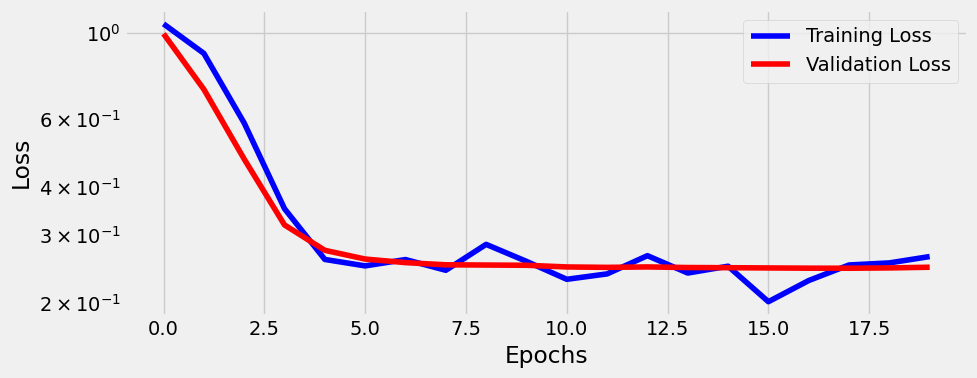

In [44]:
fig = sbs_cnn1.plot_losses()

In [45]:
@staticmethod
def _visualize_tensors(axs, x, y=None, yhat=None, 
                       layer_name='', title=None):
    # The number of images is the number of subplots in a row
    n_images = len(axs)
    # Gets max and min values for scaling the grayscale
    minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
    # For each image
    for j, image in enumerate(x[:n_images]):
        ax = axs[j]
        # Sets title, labels, and removes ticks
        if title is not None:
            ax.set_title(f'{title} #{j}', fontsize=12)
        shp = np.atleast_2d(image).shape
        ax.set_ylabel(
            f'{layer_name}\n{shp[0]}x{shp[1]}',
            rotation=0, labelpad=40
        )
        xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
        xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
        xlabel = f'{xlabel1}{xlabel2}'
        if len(xlabel):
            ax.set_xlabel(xlabel, fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

        # Plots weight as an image
        ax.imshow(
            np.atleast_2d(image.squeeze()),
            cmap='gray', 
            vmin=minv, 
            vmax=maxv
        )
    return

setattr(StepByStep, '_visualize_tensors', _visualize_tensors)

In [46]:
def visualize_filters(self, layer_name, **kwargs):
    try:
        # Gets the layer object from the model
        layer = self.model
        for name in layer_name.split('.'):
            layer = getattr(layer, name)
        # We are only looking at fitlers for 2D convolutions
        if isinstance(layer, nn.Conv2d):
            # Takes the weight information
            weights = layer.weight.data.cpu().numpy()
            # weights -> (channels_out(filter), channels_in, H, W)
            n_filters, n_channels, _, _ = weights.shape

            # Builds a figure
            size = (2 * n_channels + 2, 2 * n_filters)
            fig, axes = plt.subplots(n_filters, n_channels, figsize=size)
            axes = np.atleast_2d(axes)
            axes = axes.reshape(n_filters, n_channels)
            # For each channel_out(filter)
            for i in range(n_filters):
                StepByStep._visualize_tensors(
                    axes[i, :],
                    weights[i],
                    layer_name=f'Filter #{i}',
                    title='Channel'
                )
            for ax in axes.flat:
                ax.label_outer()
            fig.tight_layout()
            return fig
    except AttributeError:
        return

setattr(StepByStep, 'visualzie_filters', visualize_filters)

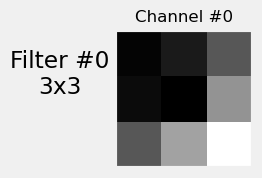

In [47]:
fig = sbs_cnn1.visualzie_filters('conv1', cmap='gray')

In [48]:
dummy_model = nn.Linear(1,1)
dummy_list = []

def dummy_hook(layer, inputs, outputs):
    dummy_list.append((layer, inputs, outputs))

In [49]:
dummy_handle = dummy_model.register_forward_hook(dummy_hook)
dummy_handle

In [50]:
dummy_x = torch.tensor([0.3])
dummy_model.forward(dummy_x)

tensor([-0.8366], grad_fn=<ViewBackward0>)

In [51]:
dummy_list

[]

In [52]:
dummy_model(dummy_x)

tensor([-0.8366], grad_fn=<ViewBackward0>)

In [53]:
dummy_list

[(Linear(in_features=1, out_features=1, bias=True),
  (tensor([0.3000]),),
  tensor([-0.8366], grad_fn=<ViewBackward0>))]

In [54]:
dummy_handle.remove()

In [55]:
modules = list(sbs_cnn1.model.named_modules())
modules

[('',
  Sequential(
    (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=16, out_features=10, bias=True)
    (relu2): ReLU()
    (fc2): Linear(in_features=10, out_features=3, bias=True)
  )),
 ('conv1', Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))),
 ('relu1', ReLU()),
 ('maxp1',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('flatten', Flatten(start_dim=1, end_dim=-1)),
 ('fc1', Linear(in_features=16, out_features=10, bias=True)),
 ('relu2', ReLU()),
 ('fc2', Linear(in_features=10, out_features=3, bias=True))]

In [57]:
layer_names = {layer: name for name, layer in modules[1:]}
layer_names

{Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1)): 'conv1',
 ReLU(): 'relu1',
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False): 'maxp1',
 Flatten(start_dim=1, end_dim=-1): 'flatten',
 Linear(in_features=16, out_features=10, bias=True): 'fc1',
 ReLU(): 'relu2',
 Linear(in_features=10, out_features=3, bias=True): 'fc2'}

In [58]:
visualization = {}

def hook_fn(layer, inputs, outputs):
    name = layer_names[layer]
    visualization[name] = outputs.detach().cpu().numpy()

In [59]:
layers_to_hook = ['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2']

handles = {}
for name, layer in modules:
    if name in layers_to_hook:
        handles[name] = layer.register_forward_hook(hook_fn)

In [61]:
images_batch, labels_batch = next(iter(val_loader))
logits = sbs_cnn1.predict(images_batch)

In [62]:
visualization.keys()

dict_keys(['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2'])

In [63]:
for handle in handles.values():
    handle.remove()

handles = {}

In [64]:
setattr(StepByStep, 'visualization', {})
setattr(StepByStep, 'handles', {})

def attach_hooks(self, layers_to_hook, hook_fn=None):
    # Clear any previous values
    self.visualization = {}
    # Creates the dictionary to map layer objects to their names
    modules = list(self.model.named_modules())
    layer_names = {layer: name for name, layer in modules[1:]}

    if hook_fn is None:
        # Hook function to be attached to the forward pass
        def hook_fn(layer, inputs, outputs):
            # Gets the layer name
            name = layer_names[layer]
            # Detaches outputs
            values = outputs.detach().cpu().numpy()
            # Since the hook function may be called multiple times
            # for example, if we make predictions for multiple mini-batches
            # it concatenates the results
            if self.visualization[name] is None:
                self.visualization[name] = values
            else:
                self.visualization[name] = np.concatenate([self.visualization[name], values])

    for name, layer in modules:
        # If the layer is in our list
        if name in layers_to_hook:
            # Initializes the corresponding key in the dictionary
            self.visualization[name] = None
            # Register the forward hook and keep the handle in another dict
            self.handles[name] = layer.register_forward_hook(hook_fn)

def remove_hooks(self):
    # Loops through all hooks and removes them
    for handle in self.handles.values():
        handle.remove()
    # Clear the dict, as all hooks have been removed
    self.handles = {}
    
setattr(StepByStep, 'attach_hooks', attach_hooks)
setattr(StepByStep, 'remove_hooks', remove_hooks)

In [65]:
sbs_cnn1.attach_hooks(
    layers_to_hook=['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2']
)

In [66]:
images_batch, labels_batch = next(iter(val_loader))
logits = sbs_cnn1.predict(images_batch)

In [67]:
sbs_cnn1.remove_hooks()

In [68]:
predicted = np.argmax(logits, 1)
predicted

array([2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 0, 1, 2, 1, 2, 0], dtype=int64)

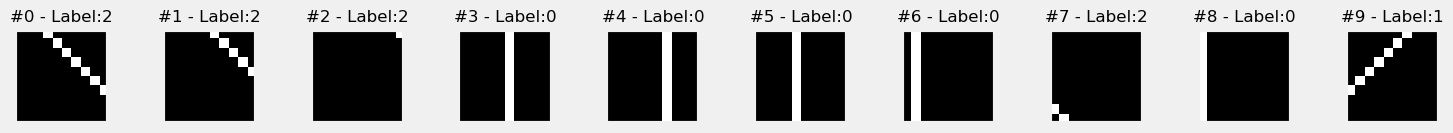

In [69]:
fig = plot_images(images_batch.squeeze(), labels_batch.squeeze(), n_plot=10)

In [70]:
def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
    layers = filter(lambda l: l in self.visualization.keys(), layers)
    layers = list(layers)
    shapes = [self.visualization[layer].shape for layer in layers]
    n_rows = [shape[1] if len(shape) == 4 else 1 
              for shape in shapes]
    total_rows = np.sum(n_rows)

    fig, axes = plt.subplots(total_rows, n_images, 
                             figsize=(1.5*n_images, 1.5*total_rows))
    axes = np.atleast_2d(axes).reshape(total_rows, n_images)
    
    # Loops through the layers, one layer per row of subplots
    row = 0
    for i, layer in enumerate(layers):
        start_row = row
        # Takes the produced feature maps for that layer
        output = self.visualization[layer]
            
        is_vector = len(output.shape) == 2
        
        for j in range(n_rows[i]):
            StepByStep._visualize_tensors(
                axes[row, :],
                output if is_vector else output[:, j].squeeze(),
                y, 
                yhat, 
                layer_name=layers[i] \
                           if is_vector \
                           else f'{layers[i]}\nfil#{row-start_row}',
                title='Image' if (row == 0) else None
            )
            row += 1
            
    for ax in axes.flat:
        ax.label_outer()

    plt.tight_layout()
    return fig

setattr(StepByStep, 'visualize_outputs', visualize_outputs)

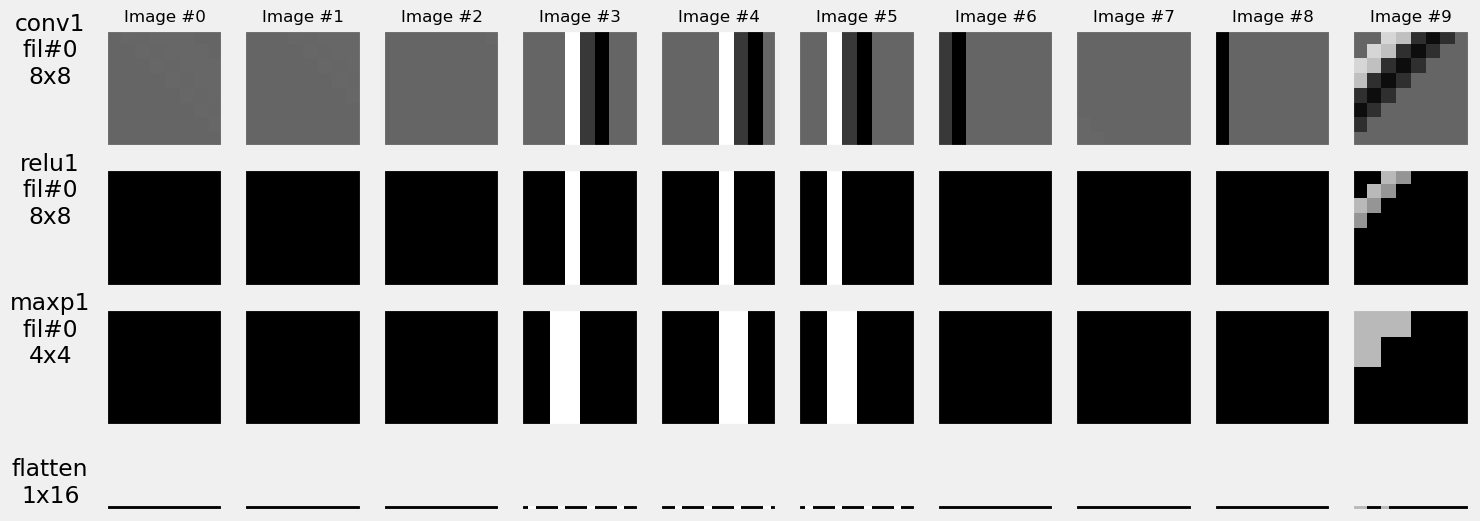

In [74]:
featurizer_layers = ['conv1', 'relu1', 'maxp1', 'flatten']

fig = sbs_cnn1.visualize_outputs(featurizer_layers)

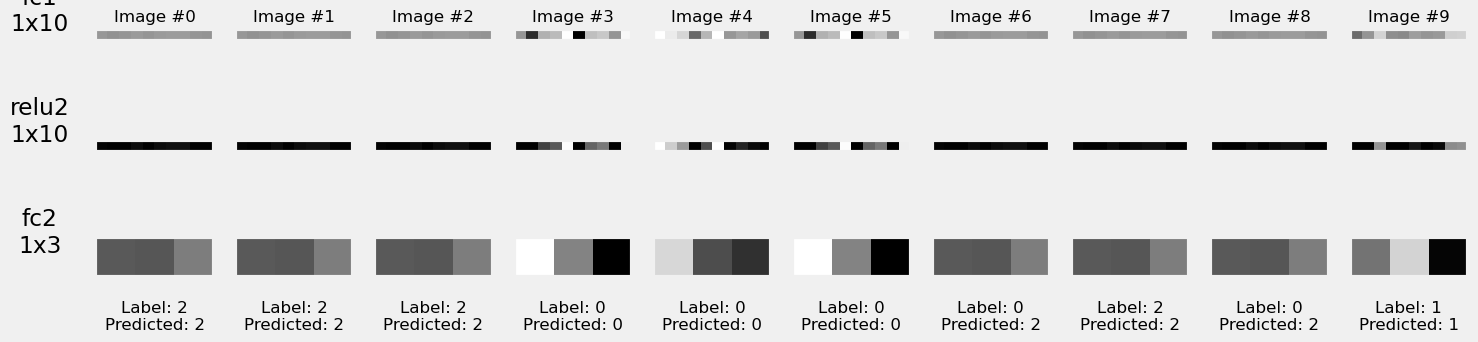

In [76]:
classifier_layers = ['fc1', 'relu2', 'fc2']
fig = sbs_cnn1.visualize_outputs(classifier_layers, y=labels_batch, yhat=predicted)

In [77]:
def correct(self, x, y, threshold=.5):
    self.model.eval()
    yhat = self.model(x.to(self.device))
    y = y.to(self.device)
    self.model.train()
    
    # We get the size of the batch and the number of classes 
    # (only 1, if it is binary)
    n_samples, n_dims = yhat.shape
    if n_dims > 1:        
        # In a multiclass classification, the biggest logit
        # always wins, so we don't bother getting probabilities
        
        # This is PyTorch's version of argmax, 
        # but it returns a tuple: (max value, index of max value)
        _, predicted = torch.max(yhat, 1)
    else:
        n_dims += 1
        # In binary classification, we NEED to check if the
        # last layer is a sigmoid (and then it produces probs)
        if isinstance(self.model, nn.Sequential) and \
           isinstance(self.model[-1], nn.Sigmoid):
            predicted = (yhat > threshold).long()
        # or something else (logits), which we need to convert
        # using a sigmoid
        else:
            predicted = (F.sigmoid(yhat) > threshold).long()
    
    # How many samples got classified correctly for each class
    result = []
    for c in range(n_dims):
        n_class = (y == c).sum().item()
        n_correct = (predicted[y == c] == c).sum().item()
        result.append((n_correct, n_class))
    return torch.tensor(result)

setattr(StepByStep, 'correct', correct)

In [78]:
sbs_cnn1.correct(images_batch, labels_batch)

tensor([[5, 7],
        [3, 3],
        [6, 6]])

In [79]:

@staticmethod
def loader_apply(loader, func, reduce='sum'):
    results = [func(x, y) for i, (x, y) in enumerate(loader)]
    results = torch.stack(results, axis=0)

    if reduce == 'sum':
        results = results.sum(axis=0)
    elif reduce == 'mean':
        results = results.float().mean(axis=0)
    
    return results

setattr(StepByStep, 'loader_apply', loader_apply)

In [80]:
StepByStep.loader_apply(sbs_cnn1.val_loader, sbs_cnn1.correct)

tensor([[59, 67],
        [55, 62],
        [71, 71]])